Формулировка задачи. У нас в базе данных лежат балансы трех банков на сбер втб юник. нужно построить модель, которая прогнозирует размер депозитов физ лиц в вследующем месяце, каждого из этих банков.

In [2]:
!pip install mysql-connector

     |████████████████████████████████| 11.9MB 50kB/s 
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql-connector


In [0]:
# В файле изпользуется версия Python 3.6.7, задание выполнялось на платформе Cоlab
# Проверка версии Python:
# import platform
# print(platform.python_version())

In [0]:
import mysql.connector

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
# from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
# from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from itertools import product #для комбинаций параметров по заданным границам
from dateutil.relativedelta import *

In [5]:
#Чтобы взять данные, используем mysql-connector
connector = mysql.connector.connect(host='80.78.255.167',
#                          database='information_schema',
                         user='igorsber',
                         password='sber123',
                         database = "sberbank"
                                   )
cursor = connector.cursor()
# Смотрим, какие таблицы доступны в базе 
cursor.execute("SHOW TABLES")
for (table_name,) in cursor:
  print(table_name)

ru_bank_balance_sheet


In [0]:
# connector = mysql.connector.connect(host='80.78.255.167',
# #                          database='information_schema',
#                          user='igorsber',
#                          password='sber123',
#                          database = "sberbank")
# cursor = connector.cursor()
# databases = ("show databases")
# cursor.execute(databases)
# for (databases) in cursor:
#      print( databases[0])

In [0]:
# Загрузим ru_bank_balance_sheet в Pandas, взяв в качестве индекса report_date
df11 = pd.read_sql("SELECT * FROM ru_bank_balance_sheet" , con=connector, index_col=['report_date'],  parse_dates=['report_date'])

In [8]:
df11.head()

,bank_id,account_id,amount_rur,amount_usd
report_date,,,,
2017-03-01,1115,20202,57981.0,29980.0
2017-03-01,1115,20208,25352.0,0.0
2017-03-01,1115,20209,0.0,0.0
2017-03-01,1115,30102,82261.0,0.0
2017-03-01,1115,30110,5414.0,28693.0


In [9]:
df11.info()
# df11.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3260763 entries, 2017-03-01 to 2008-02-01
Data columns (total 4 columns):
bank_id       int64
account_id    object
amount_rur    float64
amount_usd    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 124.4+ MB


In [0]:
#Сохраняю для себя на всякий пожарный
# df11.to_csv('ru_bank_balance_sheet.csv', index=None)

##1481 -Cбер

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


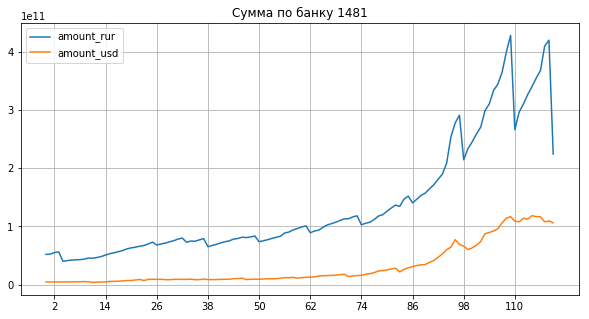

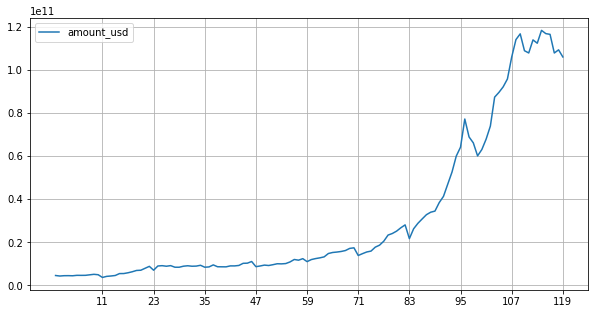

In [11]:
#выведем оба вида вкладов по валюте
import matplotlib.ticker as ticker


size=(10,5)
plt.figure(figsize =size)
BankID=1481
plt.plot(df11[df11.bank_id==BankID][['amount_rur']].groupby('report_date').sum().values, label= 'amount_rur' )
plt.plot(df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum().values, label = 'amount_usd')

ax = plt.axes()
ax.set_xticks(range(2,121,12))
plt.legend()
plt.grid()

plt.title(f'Сумма по банку {BankID}')
plt.figure(figsize=size)
plt.plot(df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum().values, label = 'amount_usd')
ax = plt.axes()
ax.set_xticks(range(11,121,12))
plt.legend()
plt.grid()


Из графиков выше видно, что есть сезонность. Посмотрим на тренд  за вычетом сезонной составляющей - используем сезонную STL декомпозицию  "Seasonal decomposition using moving averages". Получим оценку значимости по критерию Дики-Фуллера. 

In [0]:
def plot_tsa(res):
    plt.plot(res.observed, label= 'observed')
    plt.plot(res.trend, label= 'trend')
    plt.plot(res.seasonal, label= 'seasonal')
    plt.plot(res.resid, label= 'resid')
    plt.legend()

Критерий Дики-Фуллера p = 0.0005035409192323092  amount_rur


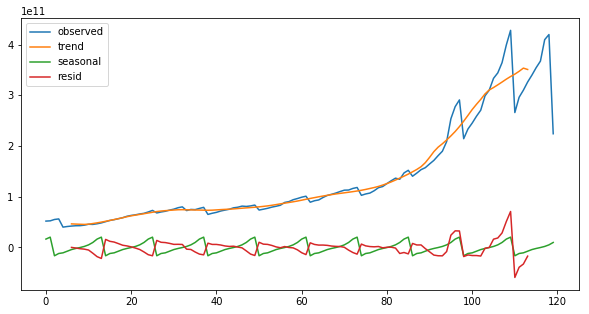

In [13]:
dataDF = df11[df11.bank_id==BankID][['amount_rur']].groupby('report_date').sum()
#Проверка на стационарность 
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.iloc[:,0].values,  freq=12)#.plot()#, image_hight=1000)
plot_tsa(res )
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.iloc[:,0].values)[1]}  amount_rur')

Критерий Дики-Фуллера p = 0.23375976960128692 для amount_usd 


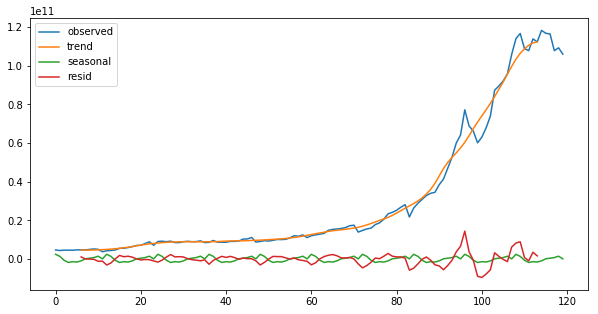

In [14]:
dataDF = df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum()
#Проверка на стационарность 
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.iloc[:,0].values,  freq=12 )
plot_tsa(res )
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.iloc[:,0].values)[1]} для amount_usd ')

In [0]:
dataDF_rur = df11[df11.bank_id==BankID][['amount_rur']].groupby('report_date').sum()
dataDF_usd = df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum()

Сезонная составялющая мала по сравнению с уровнем в обоих случаях. Для рублевых вкладов нулевая гипотеза о нестационарности ряда отвергается по ДФ - это неверная оценка, т.к. явно задан тренд. Ряд для долларовых вкладов не стационарен по критерию ДФ.

##1481 -Cбер. Для рублевых депозитов

Оптимальный параметр преобразования Бокса-Кокса: -0.503539
Критерий Дики-Фуллера p = 0.19916382836457414 


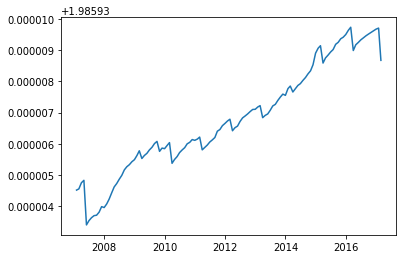

In [16]:
#Стабилизируем дисперсию 
dataDF = dataDF_rur
lmax = scs.boxcox_normmax(dataDF.iloc[:,0], brack=(-2.1, 2),  method='mle') 
dataDF['box'] = scs.boxcox(dataDF.iloc[:,0], lmax)
plt.plot(dataDF.box)
# plt.plot(dataDF.amount_rur)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmax)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box.values)[1]} ')


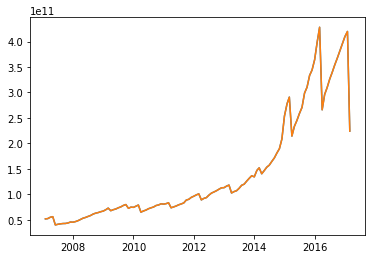

In [17]:
# обратное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
#Проверка:
plt.plot(invboxcox(dataDF.box, lmax))
plt.plot(dataDF.amount_rur)

In [0]:
# dataDF.box.hist()

In [0]:
# dataDF[:20]

Критерий Дики-Фуллера p = 0.2582356241293652


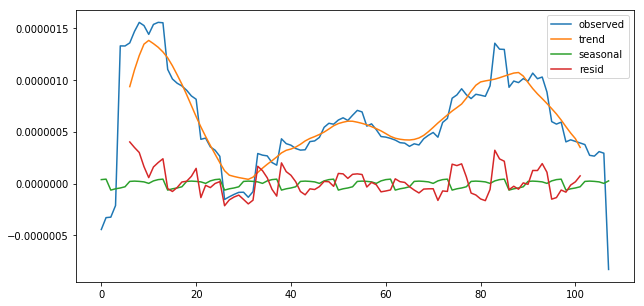

In [20]:
#Дифференцирование по сезону и  Проверка на стационарность 
dataDF['box_season_diff'] = dataDF.box - dataDF.box.shift(12)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_season_diff.values[12:],  freq=12)
plot_tsa(res )
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_season_diff.values[12:])[1]}')

In [0]:
# dataDF[dataDF.box_season_diff.isnull()==True].shape

Критерий Дики-Фуллера p = 1.1410412015523541e-12


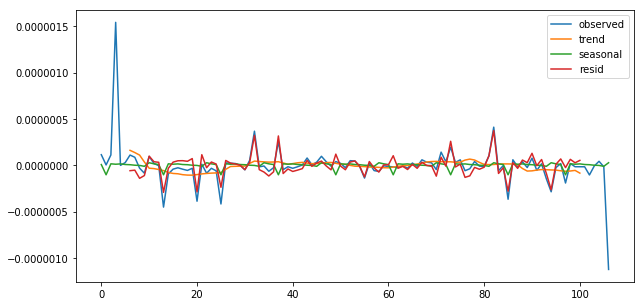

In [22]:
#Дифференцирование обычное и  Проверка на стационарность 
dataDF['box_diff2'] = dataDF.box_season_diff - dataDF.box_season_diff.shift(1)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_diff2.values[12+1:],  freq=12)
plot_tsa(res)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff2.values[12+1:])[1]}')

 Тренд колеблется вокруг константы, H0 по ДФ уверенно отвергается. Можно ряд считать стационарным




In [0]:
# dataDF['box_diff3'] = dataDF.box_diff2 - dataDF.box_diff2.shift(1)
# plt.figure(figsize=(10,5))
# res=sm.tsa.seasonal_decompose(dataDF.box_diff3.values[12+2:],  freq=12)
# plot_tsa(res)
# print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff3.values[12+2:])[1]}')

 Выведем кореллограммы ACF и PACF, чтобы прикинуть границы гиперпараметров  q, Q, p, P, которые будем использовать при поиске оптимального набора гиперпараметров.  Параметры d и D равны единице 


In [0]:
def plot_Correl(y, lags=None, figsize=(12, 7), style='bmh', title = 'Ряд после всех преобразований'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05 ,)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        print(f"Критерий Дики-Фуллера: p= {sm.tsa.stattools.adfuller(y)[1]}")
        plt.tight_layout()
    return

Критерий Дики-Фуллера: p= 1.1410412015523541e-12


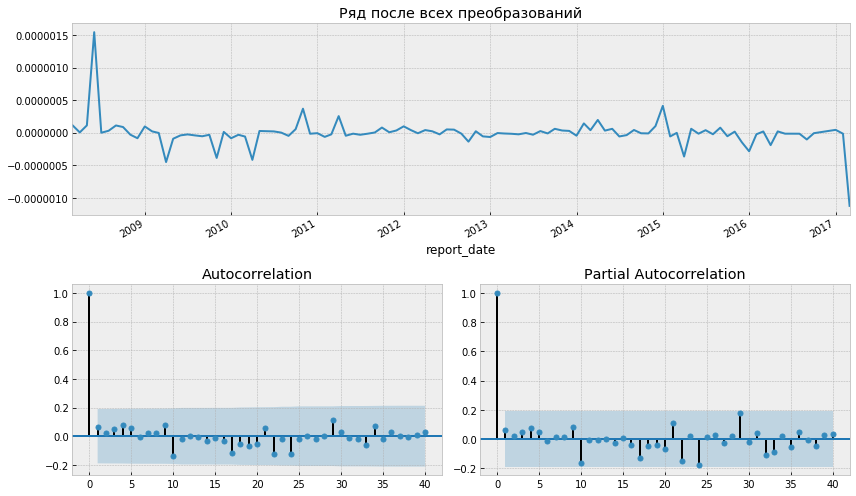

In [25]:
plot_Correl(dataDF.box_diff2[12+1:], lags=40)

Лаги по обоим коррелограммам не отличаются значимо от нуля в пределах 95% заданного интервала . Все параметры можно брать равными нулю. Чтобы не ошибиться, возьмем границы чуть больше (100 комбинаций модель считает около минуты). 

In [26]:
#Задаем сетку параметров
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [0]:
# dataDF[dataDF.box.isnull()==True]

In [0]:
#Функция оценивающая модели по критерию Акаике для сетки параметров
def get_best_params(parameters_list, data_to_model):
  results = []
  best_aic = float("inf")
  warnings.filterwarnings('ignore')#отключения предупреждений о расходящихся моделях
  for param in parameters_list:
      #try except нужен, потому что на некоторых наборах параметров модель не обучается
      try:
          model=sm.tsa.statespace.SARIMAX(data_to_model, order=(param[0], d, param[1]),   
                                          seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
      #выводим параметры, на которых модель не обучается и переходим к следующему набору
      except ValueError:
          #print('wrong parameters:', param)
          continue
      aic = model.aic
      #сохраняем лучшую модель, aic, параметры
      if aic < best_aic:
          best_model = model
          best_aic = aic
          best_param = param
      results.append([param, model.aic])

  warnings.filterwarnings('default')

  result_table = pd.DataFrame(results)
  result_table.columns = ['parameters', 'aic']
  print(result_table.sort_values(by = 'aic', ascending=True).head(4))
  return best_model

Выведем результаты, начиная с минимальных значений критерия Акаике (aic)

In [29]:
%%time
best_model = get_best_params(parameters_list, dataDF.box*1000) #умножил данные на 1000, т.к. модель выдавала ошибку связанную с малыми значениями
# print(result_table.sort_values(by = 'aic', ascending=True).head(4))

     parameters          aic
0  (0, 0, 0, 0) -1498.307677
8  (1, 0, 0, 0) -1496.981851
4  (0, 1, 0, 0) -1496.940303
2  (0, 0, 1, 0) -1496.402875
CPU times: user 8.68 s, sys: 5.18 s, total: 13.9 s
Wall time: 7.14 s


Как  ожидалось, лучшая модель (с минимальным aic) содержит нулевой набор параметров

In [0]:
# print(best_model.summary())

Критерий Стьюдента: p = 0.8645056834185597


(array([ 1.,  0.,  4., 13., 85.,  3.,  0.,  0.,  0.,  1.]),
 array([-1.12251575e-03, -8.56078145e-04, -5.89640540e-04, -3.23202934e-04,
        -5.67653286e-05,  2.09672277e-04,  4.76109882e-04,  7.42547488e-04,
         1.00898509e-03,  1.27542270e-03,  1.54186030e-03]),
 <a list of 10 Patch objects>)

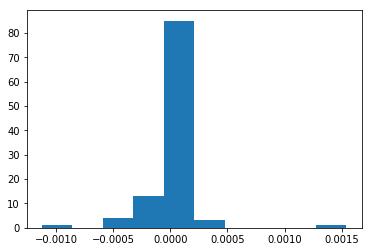

In [31]:
print(f'Критерий Стьюдента: p = {scs.ttest_1samp(best_model.resid[13:], 0)[1]}')
plt.hist(best_model.resid[12+1:])

Критерий Стьюдента не отвергает гипотезу о несмещенности остатков. 

In [0]:
#для отрисовки финального плота
def print_final (dataDF, model, gt, gt_name, devide=1):
  plt.figure(figsize=(10,5))
  plt.plot(gt.values,label = gt_name)

  dataDF["arima_model_fit"] = invboxcox(best_model.fittedvalues/devide, lmax)
  plt.plot(dataDF.arima_model_fit.values, label = 'Sarima model fit')

  fcast =model.get_forecast(1)
  fcast_x = fcast.conf_int(alpha=0.05).index
  low_b_y = invboxcox(fcast.conf_int()['lower box']/devide,lmax).values
  up_b_y = invboxcox(fcast.conf_int()['upper box']/devide,lmax).values
  mean_y = invboxcox(fcast.predicted_mean/devide,lmax).values
  mean_y, low_b_y, up_b_y
  plt.scatter(fcast_x, low_b_y,  s=17, label = f'Нижняя граница 95% интервала')
  plt.scatter(fcast_x, up_b_y,  s=17 , label = f'Верхняя граница 95% интервала' )
  plt.scatter(fcast_x, mean_y,  s=17, label = f'Прогноз (среднее) на следующий месяц - {(dataDF.index[-1] +relativedelta(months=+1)).date()}')
  plt.title(f'среднее значение прогноза: {mean_y}')
  plt.legend()

##1481 -Cбер. Прогноз, рубли

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start

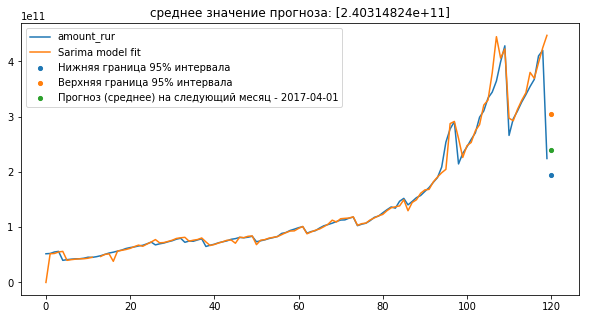

In [33]:

model=sm.tsa.statespace.SARIMAX(dataDF.box[:]*1000, order=(0, d, 0), 
                                          seasonal_order=(0, D, 0, 12)).fit(disp=-1)
print_final(dataDF, model, dataDF.amount_rur, 'amount_rur', devide = 1000)

##1481 -Cбер. Для USD депозитов

Оптимальный параметр преобразования Бокса-Кокса: -0.351645
Критерий Дики-Фуллера p = 0.6273250903672579 


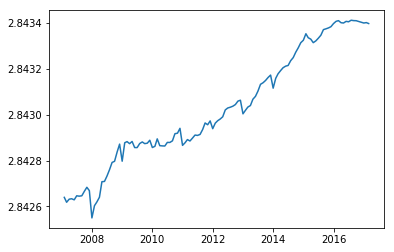

In [34]:
#Стабилизируем дисперсию 
dataDF = dataDF_usd
lmax = scs.boxcox_normmax(dataDF.iloc[:,0], brack=(-2.1, 2),  method='mle') 
dataDF['box'] = scs.boxcox(dataDF.iloc[:,0], lmax)
plt.plot(dataDF.box)
# plt.plot(dataDF.amount_rur)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmax)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box.values)[1]} ')


In [0]:
# #Проверка:
# plt.plot(invboxcox(dataDF.box, lmax))
# plt.plot(dataDF.amount_usd)

Критерий Дики-Фуллера p = 0.17691625083189677


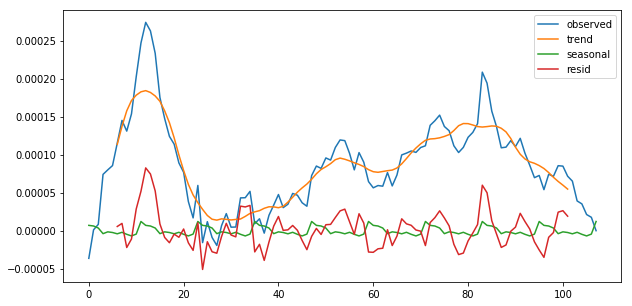

In [36]:
#Дифференцирование по сезону и  Проверка на стационарность 
dataDF['box_season_diff'] = dataDF.box - dataDF.box.shift(12)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_season_diff.values[12:],  freq=12)
plot_tsa(res )
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_season_diff.values[12:])[1]}')

In [0]:
# dataDF[dataDF.box_season_diff.isnull()==True].shape

Критерий Дики-Фуллера p = 5.221002501942211e-15


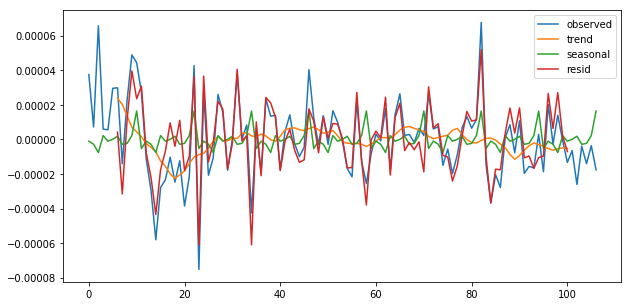

In [38]:
#Дифференцирование обычное и  Проверка на стационарность 
dataDF['box_diff2'] = dataDF.box_season_diff - dataDF.box_season_diff.shift(1)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_diff2.values[12+1:],  freq=12)
plot_tsa(res)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff2.values[12+1:])[1]}')

 Тренд почти полностью колеблется вокруг константы, H0 о нестационарности по ДФ уверенно отвергается. Можно ряд считать стационарным




In [0]:
# dataDF['box_diff3'] = dataDF.box_diff2 - dataDF.box_diff2.shift(1)
# plt.figure(figsize=(10,5))
# res=sm.tsa.seasonal_decompose(dataDF.box_diff3.values[12+2:],  freq=12)
# plot_tsa(res)
# print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff3.values[12+2:])[1]}')

 Выведем кореллограммы ACF и PACF, чтобы прикинуть границы гиперпараметров  q, Q, p, P, которые будем использовать при поиске оптимального набора гиперпараметров.  Параметры d и D равны единице 


Критерий Дики-Фуллера: p= 5.221002501942211e-15


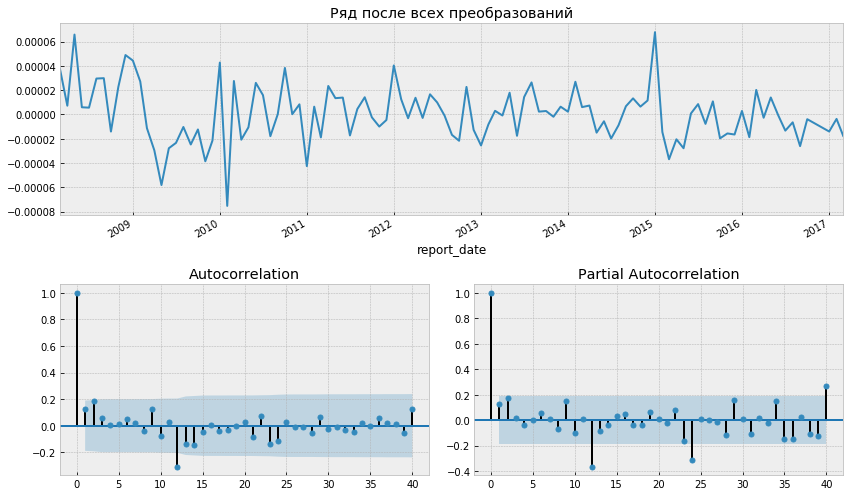

In [40]:
plot_Correl(dataDF.box_diff2[12+1:], lags=40)

В основном, лаги по обоим коррелограммам не отличаются значимо от нуля. Либо q=1, либо Q=1. Парамтр  P=2, как минимум.  Возьмем границы чуть больше этих оценок. 

In [41]:
#Задаем сетку параметров
ps = range(0, 4)
d=1
qs = range(0, 4)
Ps = range(0, 5)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

160

Выведем результаты, начиная с минимальных значений критерия Акаике (aic)

In [42]:
%%time
best_model = get_best_params(parameters_list, dataDF.box) 
# print(result_table.sort_values(by = 'aic', ascending=True).head(4))

      parameters          aic
29  (0, 3, 0, 1) -1988.027375
34  (1, 0, 0, 0) -1986.723282
59  (2, 0, 0, 0) -1986.696975
63  (2, 0, 4, 0) -1983.868621
CPU times: user 2min 52s, sys: 1min 42s, total: 4min 34s
Wall time: 2min 18s


Модель с большим ожидаемым P (P =4) содержиться в листе лучших наборов. Проверка показала, что разницы между первым и 4-ым набором нет. 

In [0]:
# print(best_model.summary())

Критерий Стьюдента: p = 0.710387015860575


(array([ 1.,  0.,  2.,  8., 31., 35., 14.,  8.,  5.,  3.]),
 array([-7.37676949e-05, -6.00610797e-05, -4.63544645e-05, -3.26478493e-05,
        -1.89412340e-05, -5.23461883e-06,  8.47199640e-06,  2.21786116e-05,
         3.58852268e-05,  4.95918421e-05,  6.32984573e-05]),
 <a list of 10 Patch objects>)

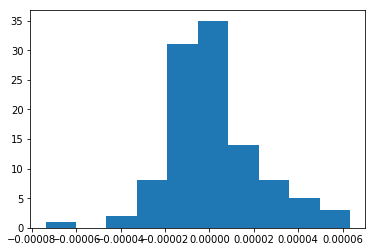

In [44]:
print(f'Критерий Стьюдента: p = {scs.ttest_1samp(best_model.resid[13:], 0)[1]}')
plt.hist(best_model.resid[12+1:])

##1481 -Cбер. Прогноз, USD

Критерий Стьюдента не отвергает гипотезу о несмещенности остатков. 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `

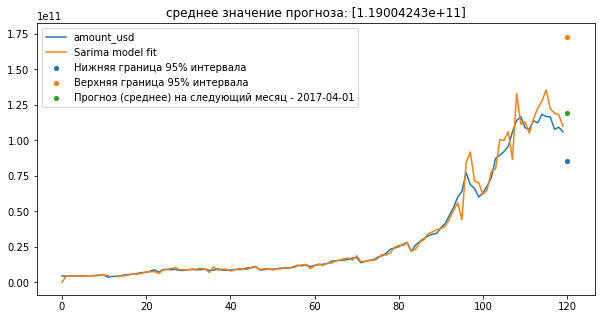

In [45]:

model=sm.tsa.statespace.SARIMAX(dataDF.box[:], order=(0, d, 3), #1040
                                          seasonal_order=(0, D, 1, 12)).fit(disp=-1)
print_final(dataDF, model, dataDF.amount_usd, 'amount_usd')

##Банк  1 (Юник)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


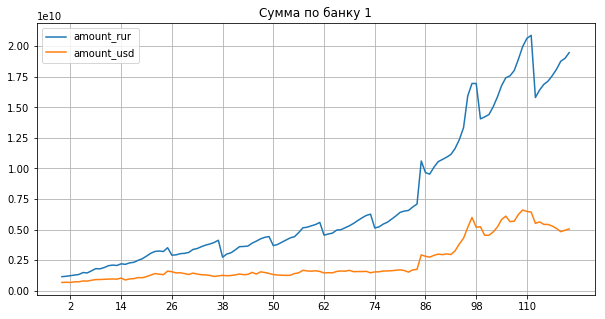

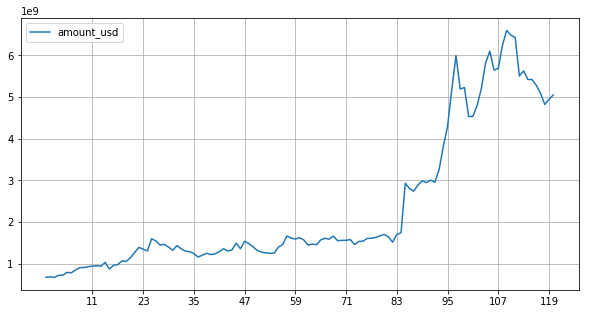

In [46]:
#выведем оба вида вкладов по валюте
import matplotlib.ticker as ticker


size=(10,5)
plt.figure(figsize =size)
BankID=1
plt.plot(df11[df11.bank_id==BankID][['amount_rur']].groupby('report_date').sum().values, label= 'amount_rur' )
plt.plot(df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum().values, label = 'amount_usd')

ax = plt.axes()
ax.set_xticks(range(2,121,12))
plt.legend()
plt.grid()

plt.title(f'Сумма по банку {BankID}')
plt.figure(figsize=size)
plt.plot(df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum().values, label = 'amount_usd')
ax = plt.axes()
ax.set_xticks(range(11,121,12))
plt.legend()
plt.grid()


Из графиков выше видно, что есть сезонность у рублевого ряда (к концу она ломается). У валютного ряда заметна лишь цикличность. Посмотрим на тренд  за вычетом сезонной составляющей - используем сезонную STL декомпозицию  "Seasonal decomposition using moving averages". Получим оценку значимости по критерию Дики-Фуллера. 

Критерий Дики-Фуллера p = 0.6473890160860909  amount_rur


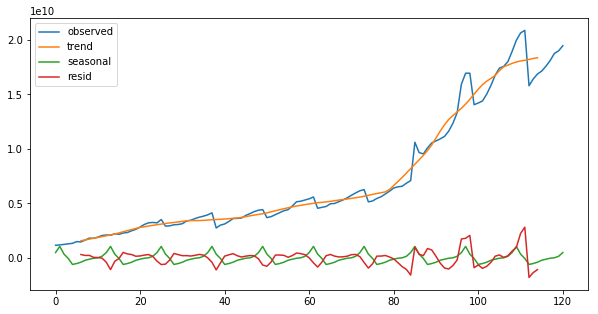

In [47]:
dataDF = df11[df11.bank_id==BankID][['amount_rur']].groupby('report_date').sum()
#Проверка на стационарность 
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.iloc[:,0].values,  freq=12)
plot_tsa(res )
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.iloc[:,0].values)[1]}  amount_rur')

Критерий Дики-Фуллера p = 0.4943196077636092 для amount_usd 


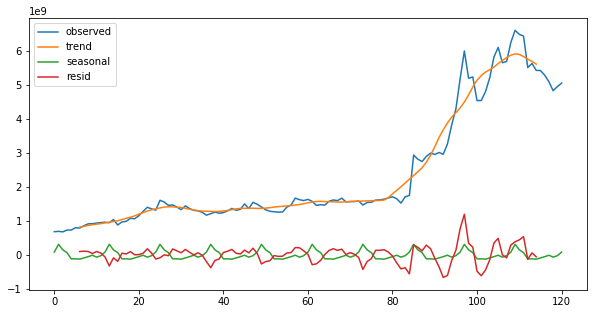

In [48]:
dataDF = df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum()
#Проверка на стационарность 
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.iloc[:,0].values,  freq=12 )
plot_tsa(res )
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.iloc[:,0].values)[1]} для amount_usd ')

In [0]:
dataDF_rur = df11[df11.bank_id==BankID][['amount_rur']].groupby('report_date').sum()
dataDF_usd = df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum()

Сезонная составялющая мала по сравнению с уровнем в обоих случаях. По ДФ оба ряда нестационарные

##Банк 1. Для рублевых депозитов

Оптимальный параметр преобразования Бокса-Кокса: -0.093004
Критерий Дики-Фуллера p = 0.8815077049260586 


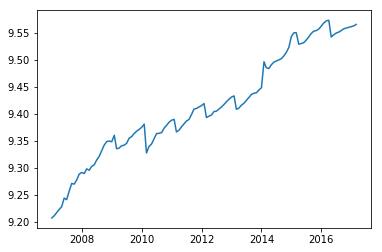

In [50]:
#Стабилизируем дисперсию 
dataDF = dataDF_rur
lmax = scs.boxcox_normmax(dataDF.iloc[:,0], brack=(-2.1, 2),  method='mle') 
dataDF['box'] = scs.boxcox(dataDF.iloc[:,0], lmax)
plt.plot(dataDF.box)
# plt.plot(dataDF.amount_rur)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmax)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box.values)[1]} ')


Критерий Дики-Фуллера p = 0.005755377772606801


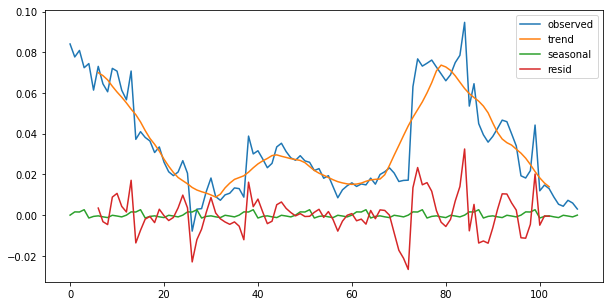

In [51]:
#Дифференцирование по сезону и  Проверка на стационарность 
dataDF['box_season_diff'] = dataDF.box - dataDF.box.shift(12)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_season_diff.values[12:],  freq=12)
plot_tsa(res )
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_season_diff.values[12:])[1]}')

In [0]:
# dataDF[dataDF.box_season_diff.isnull()==True].shape

Критерий Дики-Фуллера p = 3.719101007593212e-24


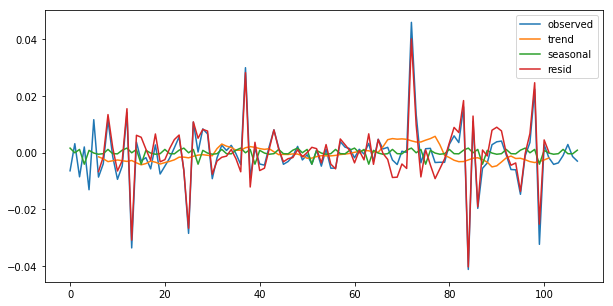

In [53]:
#Дифференцирование обычное и  Проверка на стационарность 
dataDF['box_diff2'] = dataDF.box_season_diff - dataDF.box_season_diff.shift(1)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_diff2.values[12+1:],  freq=12)
plot_tsa(res)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff2.values[12+1:])[1]}')

 Тренд колеблется вокруг константы, H0 по ДФ уверенно отвергается. Можно ряд считать стационарным




 Выведем кореллограммы ACF и PACF, чтобы прикинуть границы гиперпараметров  q, Q, p, P, которые будем использовать при поиске оптимального набора гиперпараметров.  Параметры d и D равны единице 


Критерий Дики-Фуллера: p= 3.719101007593212e-24


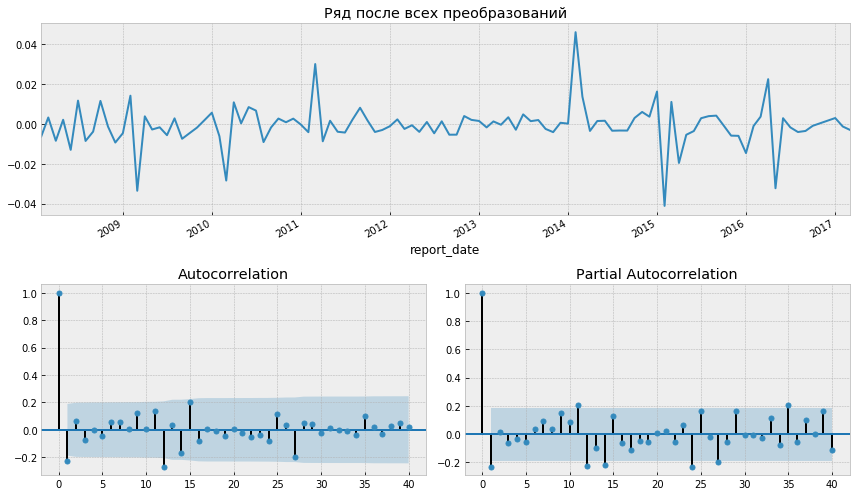

In [54]:
plot_Correl(dataDF.box_diff2[12+1:], lags=40)

Согласно ACF: q=1, Q=1. PACF: P=2, как минимум; p=1. 

In [55]:
#Задаем сетку параметров
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 4)
D=1
Qs = range(0, 4)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

Выведем результаты, начиная с минимальных значений критерия Акаике (aic)

In [56]:
%%time
best_model = get_best_params(parameters_list, dataDF.box)
# print(result_table.sort_values(by = 'aic', ascending=True).head(4))

      parameters         aic
40  (1, 0, 1, 1) -694.220503
16  (0, 1, 1, 1) -694.015847
4   (0, 0, 1, 1) -693.692381
14  (0, 1, 0, 2) -693.427793
CPU times: user 6min 3s, sys: 3min 42s, total: 9min 45s
Wall time: 4min 54s


Оптимальные значения близки к предскзанным за исключением P.

In [0]:
# print(best_model.summary())

Критерий Стьюдента: p = 0.08428820876043819


(array([ 2.,  1.,  2., 11., 72., 13.,  6.,  0.,  0.,  1.]),
 array([-0.04023243, -0.03170014, -0.02316785, -0.01463556, -0.00610327,
         0.00242902,  0.01096131,  0.0194936 ,  0.02802588,  0.03655817,
         0.04509046]),
 <a list of 10 Patch objects>)

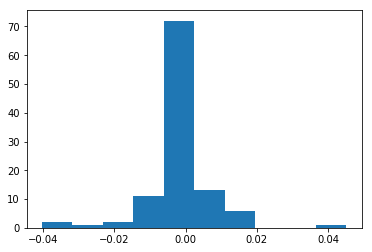

In [58]:
print(f'Критерий Стьюдента: p = {scs.ttest_1samp(best_model.resid[13:], 0)[1]}')
plt.hist(best_model.resid[12+1:])

Критерий Стьюдента не отвергает гипотезу о несмещенности остатков, но со скрипом. 

##Банк  1 (Юник). Прогноз, рубли

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning:

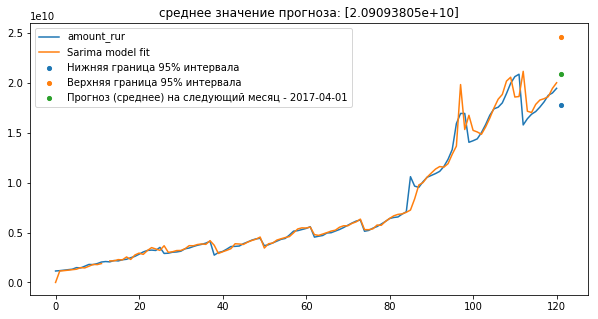

In [59]:

model=sm.tsa.statespace.SARIMAX(dataDF.box[:], order=(1, d, 0), 
                                          seasonal_order=(1, D, 1, 12)).fit(disp=-1)
print_final(dataDF, model, dataDF.amount_rur, 'amount_rur')

##Банк 1. Для USD депозитов

Оптимальный параметр преобразования Бокса-Кокса: -0.603365
Критерий Дики-Фуллера p = 0.4745166324946885 


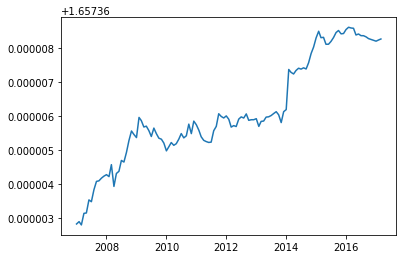

In [60]:
#Стабилизируем дисперсию 
dataDF = dataDF_usd
lmax = scs.boxcox_normmax(dataDF.iloc[:,0], brack=(-2.1, 2),  method='mle') 
dataDF['box'] = scs.boxcox(dataDF.iloc[:,0], lmax)
plt.plot(dataDF.box)
# plt.plot(dataDF.amount_rur)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmax)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box.values)[1]} ')


In [0]:
# #Проверка:
# plt.plot(invboxcox(dataDF.box, lmax))
# plt.plot(dataDF.amount_usd)

In [0]:
# #Дифференцирование по сезону и  Проверка на стационарность 
# dataDF['box_season_diff'] = dataDF.box - dataDF.box.shift(12)
# plt.figure(figsize=(10,5))
# res=sm.tsa.seasonal_decompose(dataDF.box_season_diff.values[12:],  freq=12)
# plot_tsa(res )
# print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_season_diff.values[12:])[1]}')

In [0]:
# dataDF[dataDF.box_season_diff.isnull()==True].shape

Критерий Дики-Фуллера p = 7.56126280265277e-23


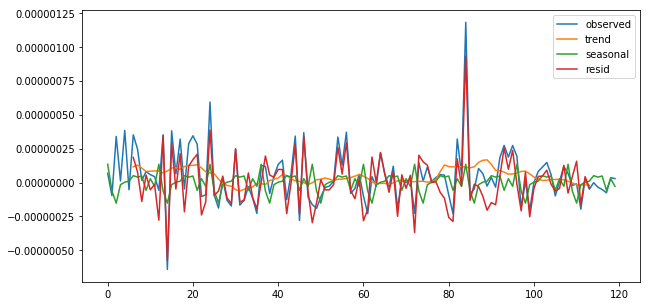

In [64]:
#Дифференцирование обычное и  Проверка на стационарность 
dataDF['box_diff1_only'] = dataDF.box - dataDF.box.shift(1)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_diff1_only.values[1:],  freq=12)
plot_tsa(res)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff1_only.values[1:])[1]}')

 После обычного дифференцирования (первые разности) тренд  колеблется вокруг константы, H0 о нестационарности по ДФ уверенно отвергается. Сезонности скорее всего нет.




In [0]:
# dataDF['box_diff3'] = dataDF.box_diff2 - dataDF.box_diff2.shift(1)
# plt.figure(figsize=(10,5))
# res=sm.tsa.seasonal_decompose(dataDF.box_diff3.values[12+2:],  freq=12)
# plot_tsa(res)
# print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff3.values[12+2:])[1]}')

 Выведем кореллограммы ACF и PACF, чтобы прикинуть границы гиперпараметров  q, Q, p, P, которые будем использовать при поиске оптимального набора гиперпараметров.  Параметры D равен  нулю на этот раз 


Критерий Дики-Фуллера: p= 7.56126280265277e-23


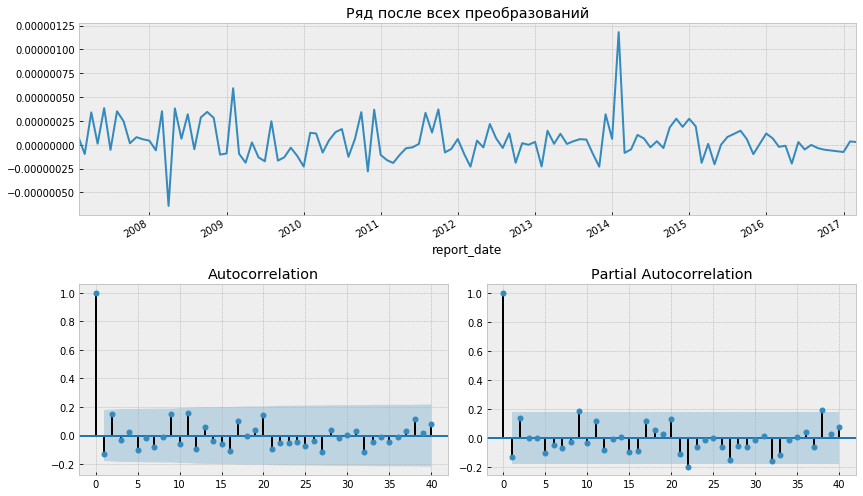

In [66]:
plot_Correl(dataDF.box_diff1_only[1:], lags=40)

В основном, лаги по обоим коррелограммам не отличаются значимо от нуля.   p =1 или 2.  Возьмем границы чуть больше этих оценок. 

In [67]:
#Задаем сетку параметров
ps = range(0, 3)
d=1
qs = range(0, 2)
Ps = range(0, 3)
D=0
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

Выведем результаты, начиная с минимальных значений критерия Акаике (aic)

In [68]:
%%time
best_model = get_best_params(parameters_list, dataDF.box*10000) #умножил данные на 10000, т.к. модель выдавала ошибку связанную с малыми значениями
# print(result_table.sort_values(by = 'aic', ascending=True).head(4))

      parameters          aic
24  (2, 0, 0, 0) -1138.083814
0   (0, 0, 0, 0) -1137.162055
30  (2, 1, 0, 0) -1136.334385
26  (2, 0, 1, 0) -1136.169795
CPU times: user 17.6 s, sys: 10.8 s, total: 28.5 s
Wall time: 14.4 s


Как  ожидалось, p=2.

In [0]:
# print(best_model.summary())
# best = best_model.resid[1:]


Критерий Стьюдента: p = 0.034046667870322615


(array([ 1.,  3., 23., 54., 23., 14.,  0.,  1.,  0.,  1.]),
 array([-0.00608454, -0.00435188, -0.00261922, -0.00088656,  0.0008461 ,
         0.00257876,  0.00431142,  0.00604408,  0.00777674,  0.0095094 ,
         0.01124206]),
 <a list of 10 Patch objects>)

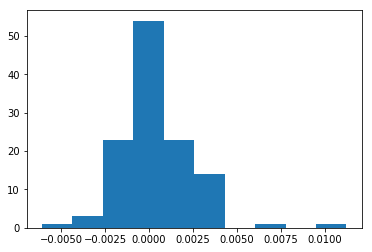

In [69]:
print(f'Критерий Стьюдента: p = {scs.ttest_1samp(best_model.resid[1:], 0)[1]}')
best = best_model.resid[1:]
plt.hist(best[abs(best) < 300])#избавимся от выброса

Критерий Стьюдента не отвергает гипотезу о несмещенности остатков. 

##Банк  1 (Юник). Прогноз USD

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


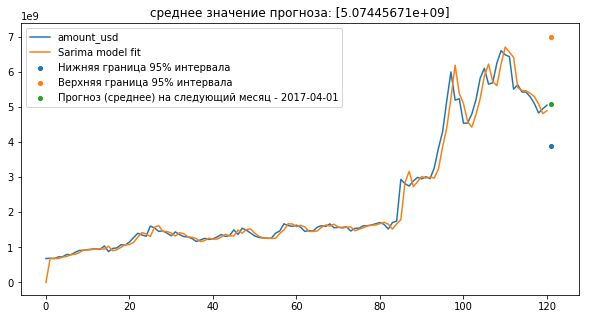

In [70]:
model=sm.tsa.statespace.SARIMAX(dataDF.box[:]*10000, order=(2, d, 0), 
                                          seasonal_order=(0, D, 1, 12)).fit(disp=-1)
print_final(dataDF, model, dataDF.amount_usd, 'amount_usd', 10000)

##Банк 1000 (ВТБ)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


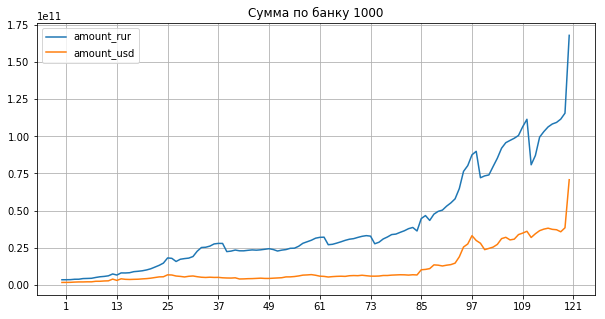

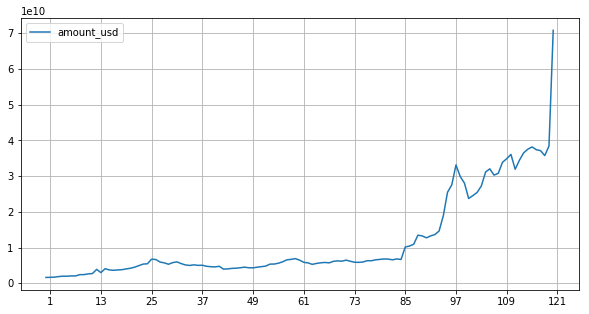

In [71]:
#выведем оба вида вкладов по валюте
size=(10,5)
plt.figure(figsize =size)
BankID=1000
plt.plot(df11[df11.bank_id==BankID][['amount_rur']].groupby('report_date').sum().values, label= 'amount_rur' )
plt.plot(df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum().values, label = 'amount_usd')

ax = plt.axes()
ax.set_xticks(range(1,130,12))
plt.legend()
plt.grid()

plt.title(f'Сумма по банку {BankID}')
plt.figure(figsize=size)
plt.plot(df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum().values, label = 'amount_usd')
ax = plt.axes()
ax.set_xticks(range(1,130,12))
plt.legend()
plt.grid()


В рублевых депозитах прослеживается сезонность. Посмотрим на тренд, предположив сезонность 12, используя "Seasonal decomposition using moving averages". Получим оценку значимости по критерию Дики-Фуллера. 

Критерий Дики-Фуллера p = 1.0  amount_rur


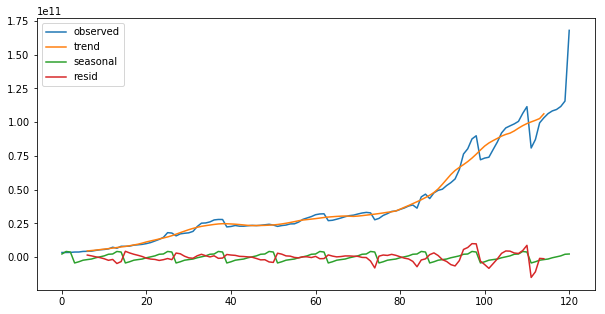

In [84]:
dataDF = df11[df11.bank_id==BankID][['amount_rur']].groupby('report_date').sum()
#Проверка на стационарность 
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.iloc[:,0].values,  freq=12)
plot_tsa(res )
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.iloc[:,0].values)[1]}  amount_rur')

Критерий Дики-Фуллера p = 1.0 для amount_usd 


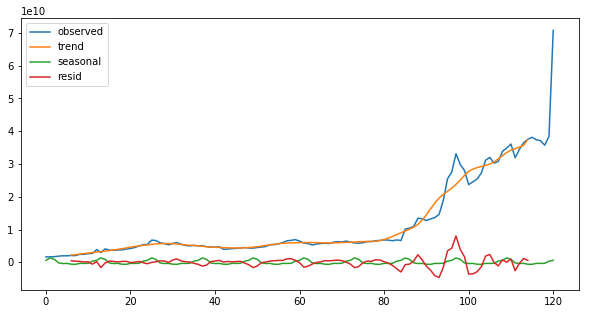

In [85]:
dataDF = df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum()
#Проверка на стационарность 
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.iloc[:,0].values,  freq=12 )
plot_tsa(res )
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.iloc[:,0].values)[1]} для amount_usd ')

In [0]:
dataDF_rur = df11[df11.bank_id==BankID][['amount_rur']].groupby('report_date').sum()
dataDF_usd = df11[df11.bank_id==BankID][['amount_usd']].groupby('report_date').sum()

##Банк 1000 (ВТБ). Для рублевых депозитов

Оптимальный параметр преобразования Бокса-Кокса: 0.188286
Критерий Дики-Фуллера p = 0.9713319212944083 


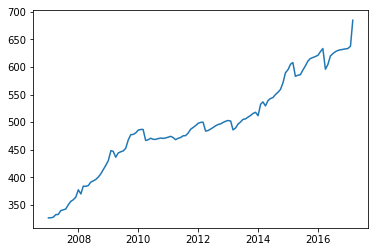

In [126]:
#Стабилизируем дисперсию 
dataDF = dataDF_rur
lmax = scs.boxcox_normmax(dataDF.iloc[:,0], brack=(-2.1, 2),  method='mle') 
dataDF['box'] = scs.boxcox(dataDF.iloc[:,0], lmax)
plt.plot(dataDF.box)
# plt.plot(dataDF.amount_rur)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmax)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box.values)[1]} ')


Критерий Дики-Фуллера p = 0.20642853660328864


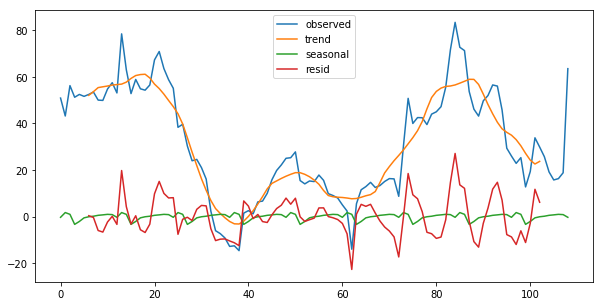

In [127]:
#Дифференцирование по сезону и  Проверка на стационарность 
dataDF['box_season_diff'] = dataDF.box - dataDF.box.shift(12)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_season_diff.values[12:],  freq=12)
plot_tsa(res )
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_season_diff.values[12:])[1]}')

Критерий Дики-Фуллера p = 0.003201137695379243


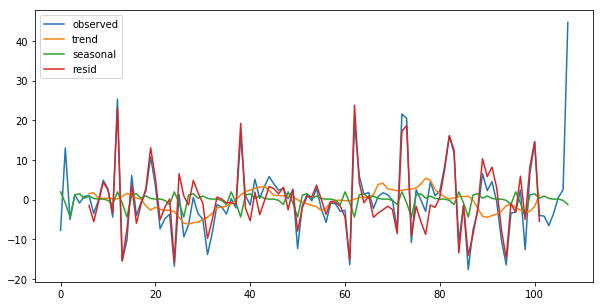

In [128]:
# Дифференцирование обычное и  Проверка на стационарность 
dataDF['box_diff2'] = dataDF.box_season_diff - dataDF.box_season_diff.shift(1)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_diff2.values[12+1:],  freq=12)
plot_tsa(res)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff2.values[12+1:])[1]}')

Критерий Дики-Фуллера p = 0.11822723325506329


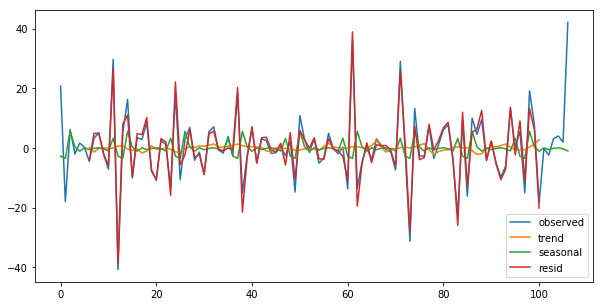

In [129]:
# Дифференцирование обычное и  Проверка на стационарность 
# dataDF['box_diff3'] = dataDF.box_diff2 - dataDF.box_diff2.shift(1)
# plt.figure(figsize=(10,5))
# res=sm.tsa.seasonal_decompose(dataDF.box_diff3.values[12+2:],  freq=12)
# plot_tsa(res)
# print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff3.values[12+2:])[1]}')

In [0]:
# Дифференцирование обычное и  Проверка на стационарность 
# dataDF['box_diff4'] = dataDF.box_diff3 - dataDF.box_diff3.shift(1)
# plt.figure(figsize=(10,5))
# res=sm.tsa.seasonal_decompose(dataDF.box_diff3.values[12+2:],  freq=12)
# plot_tsa(res)
# print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff3.values[12+2:])[1]}')

 Тренд колеблется вокруг константы, H0 по ДФ  отвергается. Можно ряд считать стационарным, хотя по сравнению с предыдущими рядами, здесь p значение не столь мало. Применение первичных разностей второй раз не дало улучшения




 Выведем кореллограммы ACF и PACF, чтобы прикинуть границы гиперпараметров  q, Q, p, P, которые будем использовать при поиске оптимального набора гиперпараметров.  d=1 и D=1


Критерий Дики-Фуллера: p= 0.003201137695379243


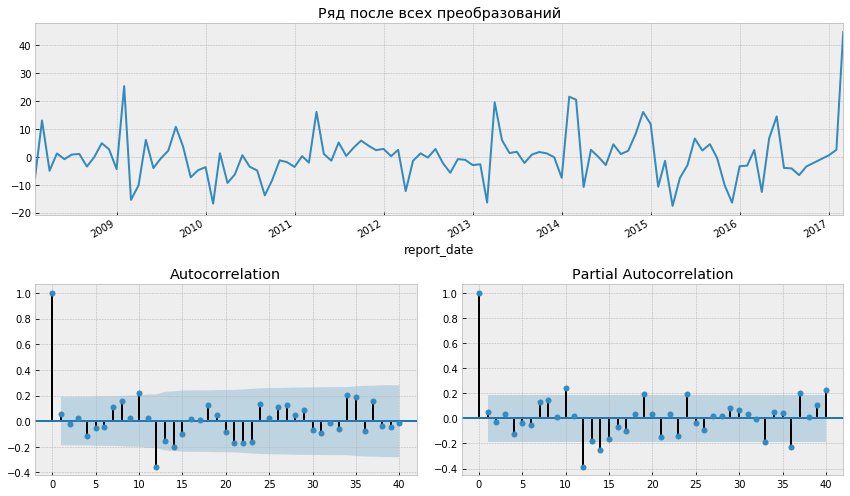

In [131]:
plot_Correl(dataDF.box_diff2[13:], lags=40)

In [132]:
#Задаем сетку параметров
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 4)
D=1
Qs = range(0, 4)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

Выведем результаты, начиная с минимальных значений критерия Акаике (aic)

In [133]:
%%time
best_model = get_best_params(parameters_list, dataDF.box)
print(result_table.sort_values(by = 'aic', ascending=True).head(4))

     parameters         aic
1  (0, 0, 0, 1)  762.767816
3  (0, 0, 1, 0)  764.385268
4  (0, 0, 1, 1)  764.640558
2  (0, 0, 0, 2)  764.690227
CPU times: user 4min 15s, sys: 2min 32s, total: 6min 47s
Wall time: 3min 24s


In [0]:
# print(best_model.summary())

Критерий Стьюдента: p = 0.965966902849339


(array([ 2.,  3., 23., 55., 17.,  4.,  2.,  0.,  0.,  1.]),
 array([-24.30438543, -17.39830392, -10.49222241,  -3.58614089,
          3.31994062,  10.22602214,  17.13210365,  24.03818516,
         30.94426668,  37.85034819,  44.7564297 ]),
 <a list of 10 Patch objects>)

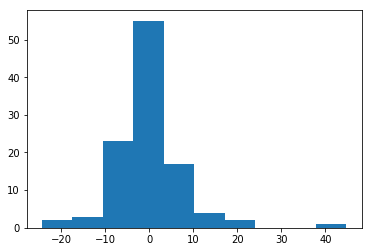

In [134]:
print(f'Критерий Стьюдента: p = {scs.ttest_1samp(best_model.resid[14:], 0)[1]}')
plt.hist(best_model.resid[12+2:])

##Банк  1000 (ВТБ). Прогноз, рубли

Критерий Стьюдента не отвергает гипотезу о несмещенности остатков 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1052: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not params_seasonal_variance == []:
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/usr/lo

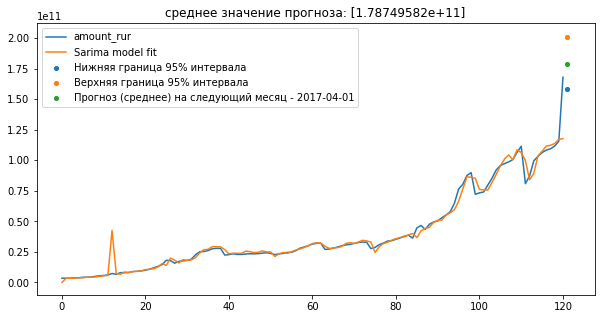

In [135]:

model=sm.tsa.statespace.SARIMAX(dataDF.box[:], order=(0, d, 0), 
                                          seasonal_order=(0, D, 1, 12)).fit(disp=-1)
print_final(dataDF, model, dataDF.amount_rur, 'amount_rur')

##Банк 1000 (ВТБ). Для USD депозитов

Оптимальный параметр преобразования Бокса-Кокса: -0.343749
Критерий Дики-Фуллера p = 0.7223926424593109 


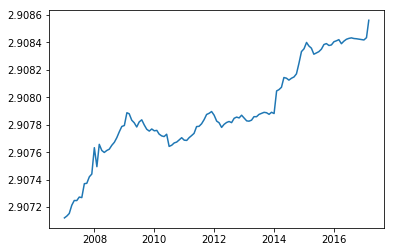

In [113]:
#Стабилизируем дисперсию 
dataDF = dataDF_usd
lmax = scs.boxcox_normmax(dataDF.iloc[:,0], brack=(-1.8, 2),  method='mle') 
dataDF['box'] = scs.boxcox(dataDF.iloc[:,0], lmax)
plt.plot(dataDF.box)
# plt.plot(dataDF.amount_rur)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmax)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box.values)[1]} ')


In [0]:
# #Проверка:
# plt.plot(invboxcox(dataDF.box, lmax))
# plt.plot(dataDF.amount_usd)

In [0]:
# dataDF[dataDF.box_season_diff.isnull()==True].shape

Критерий Дики-Фуллера p = 6.4650427063169636e-24


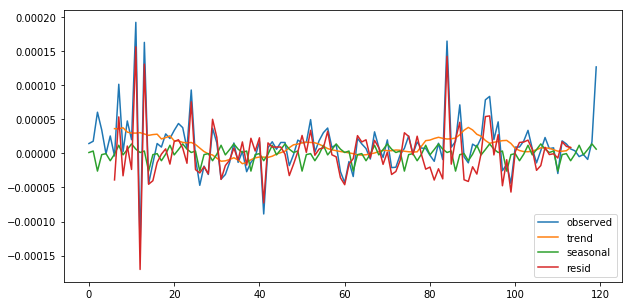

In [116]:
#Дифференцирование обычное и  Проверка на стационарность 
dataDF['box_diff1_only'] = dataDF.box - dataDF.box.shift(1)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_diff1_only.values[1:],  freq=12)
plot_tsa(res)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff1_only.values[1:])[1]}')

Критерий Дики-Фуллера p = 6.268740162216814e-08


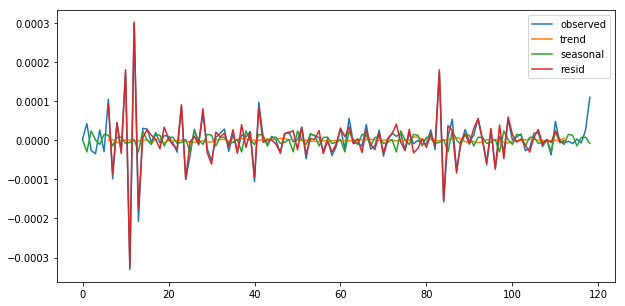

In [117]:
dataDF['box_diff2_only'] = dataDF.box_diff1_only - dataDF.box_diff1_only.shift(1)
plt.figure(figsize=(10,5))
res=sm.tsa.seasonal_decompose(dataDF.box_diff2_only.values[2:],  freq=12)
plot_tsa(res)
print(f'Критерий Дики-Фуллера p = {sm.tsa.stattools.adfuller(dataDF.box_diff2_only.values[2:])[1]}')

 После двойного обычного дифференцирования (первые разности) тренд  колеблется вокруг константы, H0 о нестационарности по ДФ уверенно отвергается. Сезонности скорее всего нет.




 Выведем кореллограммы ACF и PACF, чтобы прикинуть границы гиперпараметров  q, Q, p, P, которые будем использовать при поиске оптимального набора гиперпараметров.  Параметры D равен  нулю на этот раз, d=2


Критерий Дики-Фуллера: p= 6.268740162216814e-08


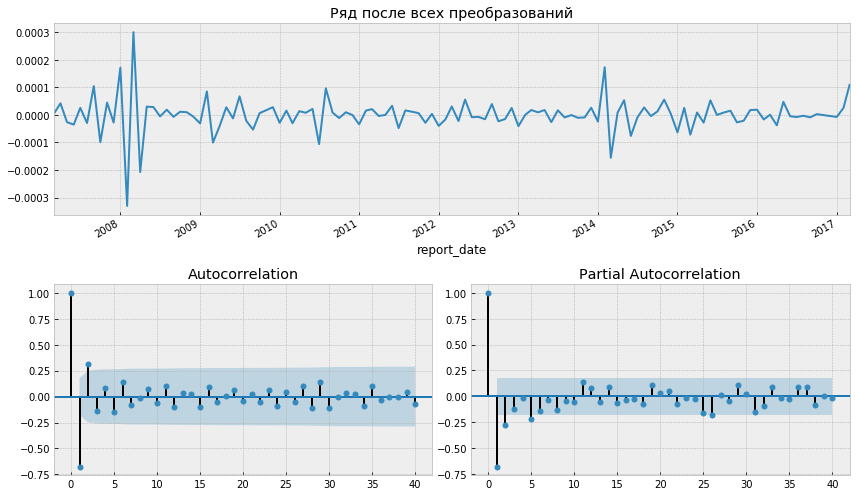

In [118]:
plot_Correl(dataDF.box_diff2_only[2:], lags=40)

Несезонные лаги: p=2, q=1

In [119]:
#Задаем сетку параметров
ps = range(0, 3)
d=2
qs = range(0, 3)
Ps = range(0, 2)
D=0
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

Выведем результаты, начиная с минимальных значений критерия Акаике (aic)

In [120]:
%%time
best_model = get_best_params(parameters_list, dataDF.box*1000) #умножил данные на 1000, т.к. модель выдавала ошибку связанную с малыми значениями
# print(result_table.sort_values(by = 'aic', ascending=True).head(4))

      parameters         aic
28  (2, 1, 0, 0) -416.490592
16  (1, 1, 0, 0) -414.938764
20  (1, 2, 0, 0) -414.904780
31  (2, 1, 1, 1) -414.838545
CPU times: user 17.1 s, sys: 10.6 s, total: 27.7 s
Wall time: 14 s


Как  ожидалось, p=2, q =1

Критерий Стьюдента: p = 0.3427278556527452


(array([ 1.,  2.,  2., 18., 44., 41.,  4.,  4.,  1.,  2.]),
 array([-0.15462056, -0.12342175, -0.09222294, -0.06102413, -0.02982532,
         0.00137349,  0.0325723 ,  0.06377111,  0.09496992,  0.12616873,
         0.15736754]),
 <a list of 10 Patch objects>)

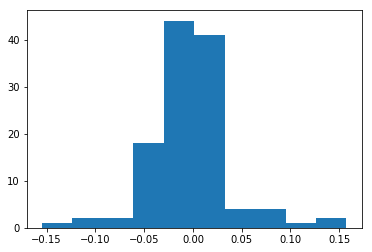

In [121]:
print(f'Критерий Стьюдента: p = {scs.ttest_1samp(best_model.resid[2:], 0)[1]}')
plt.hist(best_model.resid[2:])

##Банк  1000 (ВТБ). Прогноз, USD


Критерий Стьюдента говорит о том, что остатки не смещены.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning:

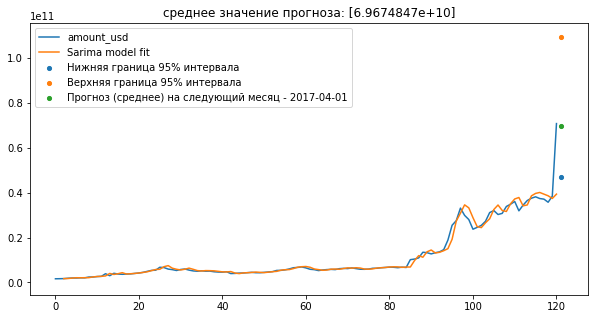

In [122]:
model=sm.tsa.statespace.SARIMAX(dataDF.box[:]*1000, order=(2, d, 1), 
                                          seasonal_order=(0, D, 0, 12)).fit(disp=-1)
print_final(dataDF, model, dataDF.amount_usd, 'amount_usd', 1000 )
